In [1]:
import os
import pickle
import tarfile
import datetime
import zipfile
import numpy as np
import urllib.request
import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

2024-05-21 12:52:50.936703: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 12:52:51.001159: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 12:52:51.576098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-05-21 12:52:54.362039: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 12:52:54.409696: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 12:52:54.409739: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
%load_ext tensorboard

In [4]:
BATCH_SIZE = 64
HISTORY_DIR = './history'
os.makedirs(HISTORY_DIR, exist_ok=True)

In [5]:
# def download_data():
#     if not os.path.exists('tiny-imagenet-200'):
#         urllib.request.urlretrieve('http://cs231n.stanford.edu/tiny-imagenet-200.zip', 'tiny-imagenet-200.zip')
#         file = zipfile.ZipFile('tiny-imagenet-200.zip', 'r')
#         file.extractall()

In [8]:
# download_data()

In [5]:
def get_dataset(path: str, image_size: tuple[int, int]) -> tf.data.Dataset:
    class_names = []
    paths = []
    labels = []
    for class_name in os.listdir(path): 
        class_path = os.path.join(path, class_name)
        
        if not os.path.isdir(class_path):
            continue

        class_label = len(class_names)
        class_names.append(class_name)

        for file in os.listdir(os.path.join(class_path, 'images')):
            if os.path.isdir(os.path.join(class_path, 'image', file)):
                continue
            paths.append(os.path.join(class_path, 'images', file))
            labels.append(class_label)
            
    rng = np.random.default_rng()

    index = rng.choice(len(labels), size=len(labels), replace=False)

    paths = np.array(paths)[index]
    labels = np.array(labels)[index]

    def read_image(path: tf.Tensor) -> tf.Tensor:
        img = tf.io.read_file(path)
        img = tf.io.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.convert_image_dtype(img, tf.float32)
        
        img = tf.image.resize_with_pad(img, *image_size)
        return img

    return tf.data.Dataset.zip(
        tf.data.Dataset.from_tensor_slices(paths).map(read_image),
        tf.data.Dataset.from_tensor_slices(labels),
    ), class_names

In [6]:
train_dataset, class_names = get_dataset("tiny-imagenet-200/train", (64, 64))

2024-05-21 12:54:37.730716: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 12:54:37.730853: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 12:54:37.730875: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 12:54:37.912403: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-21 12:54:37.912470: I external/local_xla/xla/stream_executor

In [7]:
train_dataset

<_ZipDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
len(class_names)

200

In [9]:
img, label  = next(iter(train_dataset))

In [10]:
img.shape

TensorShape([64, 64, 3])

In [11]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=24>

In [12]:
id_to_class = {k: v for k, v in enumerate(class_names)}

In [13]:
words_class_file = 'tiny-imagenet-200/words.txt'
words_class = pd.read_csv(words_class_file, sep='\t', header=None)

In [14]:
words_class.head()

,0,1
0,n00001740,entity
1,n00001930,physical entity
2,n00002137,"abstraction, abstract entity"
3,n00002452,thing
4,n00002684,"object, physical object"


In [15]:
id2name = {
i: words_class.loc[words_class[0] == k][1].values[0]
for i, k in id_to_class.items()
}

In [16]:
id3name = list(id2name.values())

Text(0.5, 1.0, 'Chihuahua')

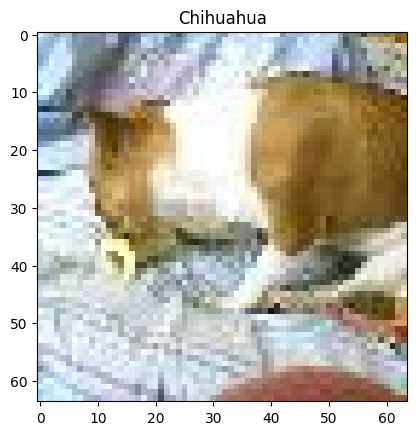

In [23]:
plt.imshow(img)
plt.title(id3name[label])
# plt.imshow(img[0, :, :, :])
# plt.title(id3name[label[0]])

In [17]:
def get_val_dataset(path: str, image_size: tuple[int, int], class_names: list[str]) -> tf.data.Dataset:
    paths = []
    labels = []
    val_txt_df = pd.read_csv(os.path.join(path, 'val_annotations.txt'), sep='\t', header=None).loc[:, [0, 1]]
    class_to_id = {v: k for k, v in enumerate(class_names)}
    
    for i, _ in val_txt_df.iterrows():
        paths.append(os.path.join(path, 'images', val_txt_df.iloc[i, 0]))
        labels.append(class_to_id[val_txt_df.iloc[i, 1]])
        
    rng = np.random.default_rng()

    index = rng.choice(len(labels), size=len(labels), replace=False)
    
    paths = np.array(paths)[index]
    labels = np.array(labels)[index]

    def read_image(path: tf.Tensor) -> tf.Tensor:
        img = tf.io.read_file(path)
        img = tf.io.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.convert_image_dtype(img, tf.float32)
        
        img = tf.image.resize_with_pad(img, *image_size)
        return img

    return tf.data.Dataset.zip(
        tf.data.Dataset.from_tensor_slices(paths).map(read_image),
        tf.data.Dataset.from_tensor_slices(labels),
    )

In [18]:
val_dataset = get_val_dataset("tiny-imagenet-200/val", (64, 64), class_names)

In [19]:
val_dataset

<_ZipDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [20]:
iterr = iter(val_dataset)

In [21]:
val_img, val_label = next(iterr)

Text(0.5, 1.0, 'dining table, board')

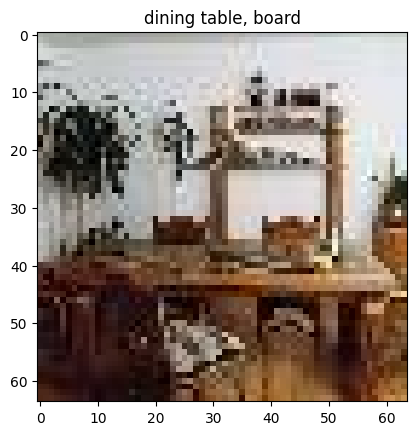

In [24]:
plt.imshow(val_img)
plt.title(id3name[val_label])
# plt.imshow(val_img[0, :, :, :])
# plt.title(id3name[val_label[0]])

In [25]:
initializer = tf.keras.initializers.HeNormal()

inputs = tf.keras.layers.Input((64, 64, 3), dtype=tf.float32, name="inputs")
input_norm = tf.keras.layers.BatchNormalization(name='b0')(inputs)

outs = []
for i in range(3):
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=initializer)(input_norm)
    x = tf.keras.layers.BatchNormalization(name=f'bn{i+1}_1')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization(name=f'bn{i+1}_2')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization(name=f'bn{i+1}_3')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization(name=f'bn{i+1}_4')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization(name=f'bn{i+1}_5')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization(name=f'bn{i+1}_6')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer=initializer)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer=initializer)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    outs.append(tf.keras.layers.Dropout(0.5)(x))
    
out = tf.keras.layers.Concatenate()(outs)    
# out = tf.keras.layers.Average()(outs)
x = tf.keras.layers.Flatten()(out)
x = tf.keras.layers.Dense(512, kernel_initializer=initializer, activation='relu')(x)
x = tf.keras.layers.BatchNormalization(name='bn4')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(200, kernel_initializer=tf.keras.initializers.GlorotUniform())(x)

model = tf.keras.Model(inputs=inputs, outputs=x, name='conv_tiny_img')

In [26]:
model.summary()

Model: "conv_tiny_img"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 64, 64, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ b0                  │ (None, 64, 64, 3) │         12 │ inputs[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,792 │ b0[0][0]          │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │      1,792 │ b0[0][0]          │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │      1,792 │ b0[0][0]          │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1_1               │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2_1               │ (None, 64, 64,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3_1               │ (None, 64, 64,    │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ bn1_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     36,928 │ bn2_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     36,928 │ bn3_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1_2               │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2_2               │ (None, 64, 64,    │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3_2               │ (None, 64, 64,    │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ bn1_2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ bn2_2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ bn3_2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                 

 Total params: 8,665,492 (33.06 MB)

 Trainable params: 8,659,086 (33.03 MB)

 Non-trainable params: 6,406 (25.02 KB)

In [27]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [28]:
logdir = os.path.join(HISTORY_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [29]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(logdir, 'model.keras'),
    save_best_only=True
)

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    os.path.join(logdir, 'logs'),    
)

In [31]:
%tensorboard --logdir $logdir

In [32]:
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [33]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [34]:
model.fit(train_dataset, validation_data=val_dataset, batch_size=BATCH_SIZE, epochs=20, callbacks=[model_checkpoint_callback, tensorboard_callback])

Epoch 1/20


I0000 00:00:1716260146.550203    9545 service.cc:145] XLA service 0x7f2300002910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716260146.550400    9545 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-05-21 12:55:46.722797: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-21 12:55:47.494558: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1716260153.381544   10050 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_9713', 112 bytes spill stores, 112 bytes spill loads

I0000 00:00:1716260153.383346   10047 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_9713', 112 bytes spill stores, 112 bytes spill lo

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 249s 143ms/step - accuracy: 0.0163 - loss: 5.5273 - val_accuracy: 0.0261 - val_loss: 10.1582
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 209s 134ms/step - accuracy: 0.0714 - loss: 4.4771 - val_accuracy: 0.1370 - val_loss: 3.9283
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 211s 135ms/step - accuracy: 0.1324 - loss: 3.9678 - val_accuracy: 0.2003 - val_loss: 3.5470
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 211s 135ms/step - accuracy: 0.1868 - loss: 3.6233 - val_accuracy: 0.2460 - val_loss: 3.3009
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 210s 134ms/step - accuracy: 0.2219 - loss: 3.4088 - val_accuracy: 0.2646 - val_loss: 3.1975
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 210s 134ms/step - accuracy: 0.2534 - loss: 3.2363 - val_accuracy: 0.3072 - val_loss: 2.9660
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 209s 134ms/step - accuracy: 0.2834 - loss: 3.0661 - val_accuracy: 0.3341 - val_loss: 2.8346
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 210s 134ms/step - accuracy: 0.

In [35]:
model.evaluate(val_dataset)

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4335 - loss: 2.4541


[2.4354145526885986, 0.4413999915122986]

In [111]:
model.save_weights('weights_imgnet.weights.h5')

In [9]:
model.load_weights('weights_imgnet.weights.h5')

In [36]:
y_true = np.concatenate([y for x, y in val_dataset], axis=0)
y_pred = model.predict(val_dataset).argmax(axis=-1)

2024-05-21 14:07:27.819358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step


In [37]:
_, ax = plt.subplots(figsize=(75, 75))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, colorbar=False)

plt.tight_layout()
plt.savefig('valid.png')

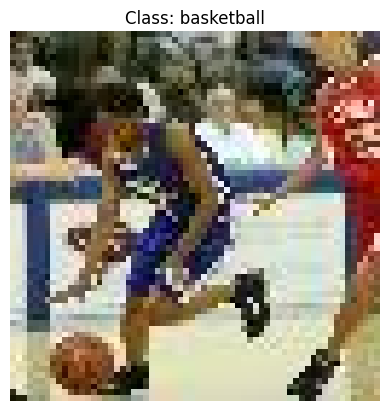

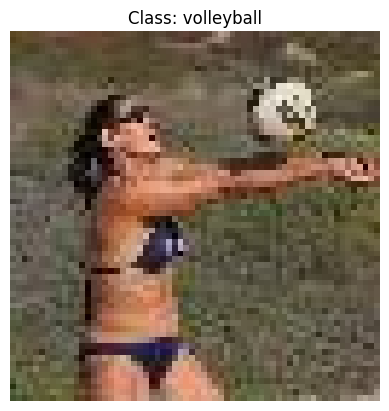

In [38]:
target_classes = [68, 171]

for images, labels in val_dataset:
    for image, label in zip(images, labels):  
        if label in target_classes:
            plt.imshow(image)
            plt.title(f'Class: {id3name[label]}')
            plt.axis('off')
            plt.show()
            target_classes.remove(label) 
            if not target_classes:
                break
    if not target_classes:
        break

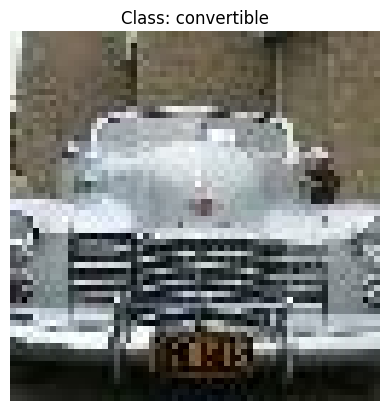

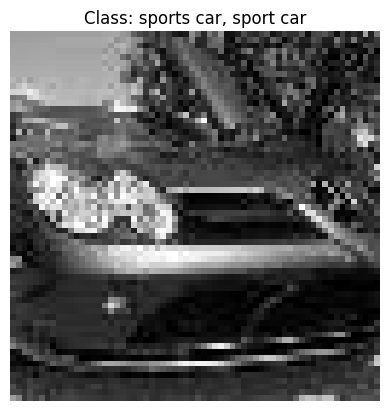

In [39]:
target_classes = [94, 153]

for images, labels in val_dataset:
    for image, label in zip(images, labels):  
        if label in target_classes:
            plt.imshow(image)
            plt.title(f'Class: {id3name[label]}')
            plt.axis('off')
            plt.show()
            target_classes.remove(label) 
            if not target_classes:
                break
    if not target_classes:
        break